In [1]:
import pandas as pd

In [2]:
df_statewise_rape = pd.read_csv("../datasets/crime analytics/20_Victims_of_rape.csv")
df_statewise_murder = pd.read_csv("../datasets/crime analytics/32_Murder_victim_age_sex.csv")
df_cases_crime_against_women = pd.read_csv("../datasets/crime analytics/42_Cases_under_crime_against_women.csv")
df_arrests_crime_against_women = pd.read_csv("../datasets/crime analytics/43_Arrests_under_crime_against_women.csv")
df_districtwise_caw = pd.read_csv("../datasets/crime analytics/crime/42_District_wise_crimes_committed_against_women_2001_2012.csv")
df_census_data = pd.read_csv("../datasets/crime analytics/census_data/district wise centroids.csv")

In [3]:
df_census_data['State'] = df_census_data['State'].str.upper().str.strip()
df_census_data['District'] = df_census_data['District'].str.upper().str.strip()

df_districtwise_caw['STATE/UT'] = df_districtwise_caw['STATE/UT'].str.upper().str.strip()
df_districtwise_caw['DISTRICT'] = df_districtwise_caw['DISTRICT'].str.upper().str.strip()

In [4]:
df_statewise_total_cases_crime_against_women = df_cases_crime_against_women[df_cases_crime_against_women['Group_Name']=='Total Crime Against Women']
df_statewise_total_arrests_crime_against_women = df_arrests_crime_against_women[df_arrests_crime_against_women['Group_Name']=='Total Crime Against Women']
df_statewise_total_rape_victims = df_statewise_rape[df_statewise_rape['Subgroup'] == 'Total Rape Victims']
df_statewise_murder_female_victims = df_statewise_murder[df_statewise_murder['Group_Name']=='Murder - Female Victims']
df__total_statewise_murder_female_victims = df_statewise_murder_female_victims.groupby(['Area_Name', 'Year']).agg({
    'Victims_Total': 'sum',
    'Victims_Above_50_Yrs': 'sum',
    'Victims_Upto_10_15_Yrs': 'sum',
    'Victims_Upto_10_Yrs': 'sum',
    'Victims_Upto_15_18_Yrs': 'sum',
    'Victims_Upto_18_30_Yrs': 'sum',
    'Victims_Upto_30_50_Yrs': 'sum'
}).reset_index()


In [5]:
dw_caw_latlong = pd.merge(df_census_data, 
                     df_districtwise_caw, 
                     left_on=['State', 'District'], 
                     right_on=['STATE/UT', 'DISTRICT'], 
                     how='inner')
dw_caw_latlong = dw_caw_latlong.drop(columns=['STATE/UT','DISTRICT'])

In [6]:
dw_caw_latlong.to_csv("./dw_caw_latlong.csv")

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [8]:
crime_features = dw_caw_latlong[['Rape', 'Kidnapping and Abduction', 'Dowry Deaths',
                     'Assault on women with intent to outrage her modesty',
                     'Insult to modesty of Women', 'Cruelty by Husband or his Relatives',
                     'Importation of Girls']]
# Standardize the crime features
scaler = StandardScaler()
crime_features_scaled = scaler.fit_transform(crime_features)

In [9]:
# Apply KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)  # Adjust n_clusters as needed
clusters = kmeans.fit_predict(crime_features_scaled)

# Add the cluster labels back to the original DataFrame
dw_caw_latlong['Cluster'] = clusters

In [10]:
from geopy.distance import great_circle

def find_nearest_district(lat, lon, df):
    # Compute the distance between the input location and all district locations
    distances = df.apply(lambda row: great_circle((lat, lon), (row['Latitude'], row['Longitude'])).km, axis=1)
    nearest_index = distances.idxmin()  # Get the index of the nearest district
    return df.loc[nearest_index, 'Cluster']  # Return the cluster label (safety rating)

# Example usage: find the safety rating for a given location
lat, lon = 28.6139, 77.2090  # Example coordinates (New Delhi)
lat2, lon2 = 12.9716, 77.5946 # bangalore
lat3, lon3 = 28.6692, 77.4538 # Ghaziabad
safety_rating = find_nearest_district(lat3, lon3, dw_caw_latlong)
print("Safety Rating (Cluster):", safety_rating)

Safety Rating (Cluster): 3


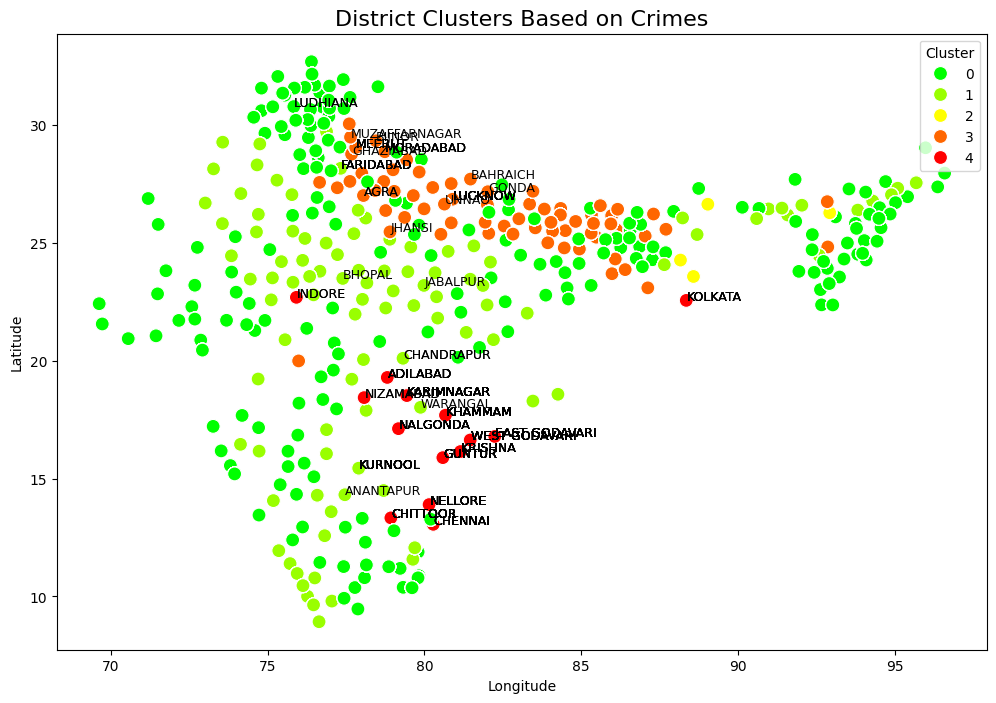

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a scatter plot of districts colored by their cluster
plt.figure(figsize=(12, 8))
custom_palette = {0: '#00FF00',  # Green
                  1: '#99FF00',
                  2: '#FFFF00',  # Yellow
                  3: '#FF6600',
                  4: '#FF0000'}  # Deep Red
sns.scatterplot(x='Longitude', y='Latitude', hue='Cluster', data=dw_caw_latlong, s=100, marker='o', palette=custom_palette)
# Annotate points belonging to the red cluster (e.g., Cluster 4)
for i, row in dw_caw_latlong[dw_caw_latlong['Cluster'] == 4].iterrows():
    plt.text(row['Longitude'] + 0.01, row['Latitude'] + 0.01, row['District'], 
             fontsize=9, color='black')

# Set plot labels and title
plt.title('District Clusters Based on Crimes', fontsize=16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Cluster', loc='upper right')

plt.show()

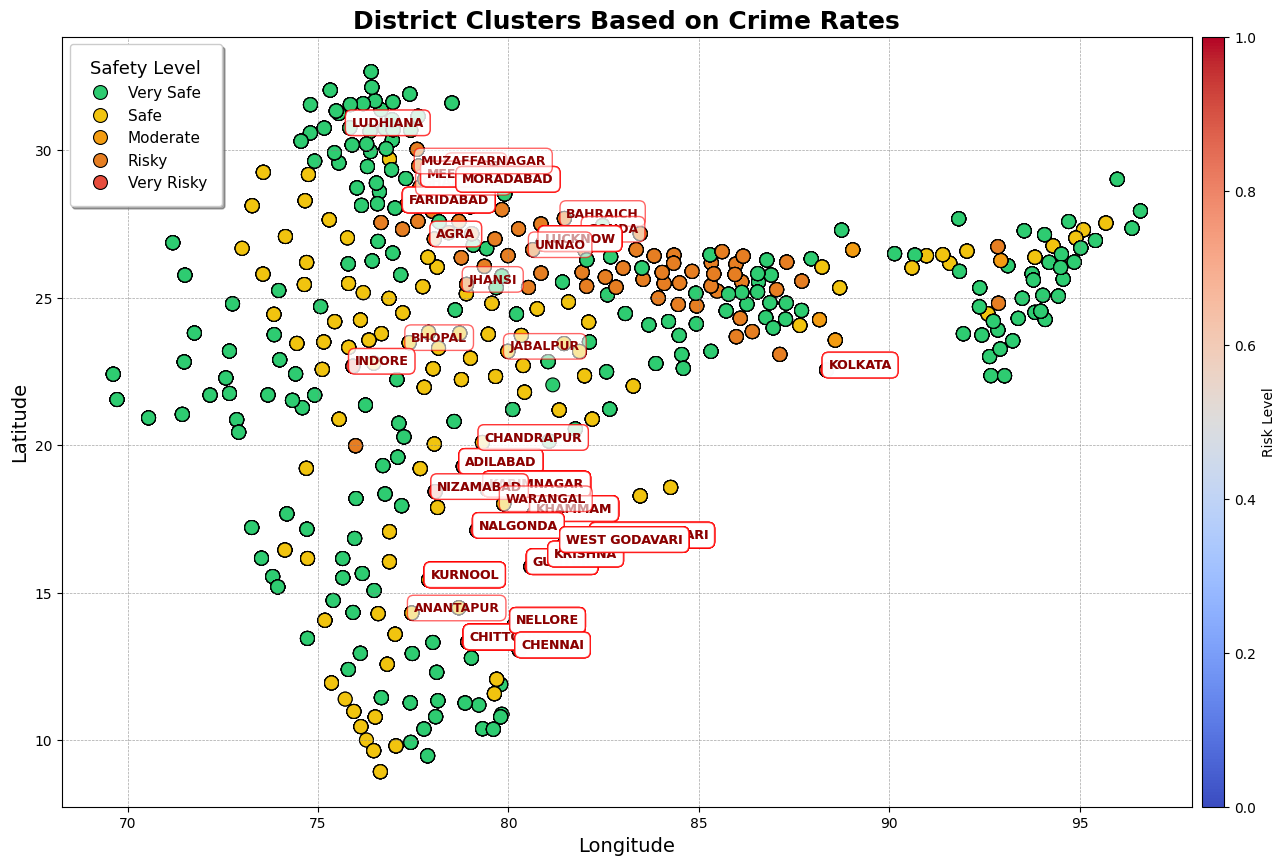

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Optional: Use a GeoDataFrame for India (requires a shapefile of India, not shown here)
# india_shapefile = 'path_to_shapefile/india_shapefile.shp'
# gdf = gpd.read_file(india_shapefile)

# Create the plot
fig, ax = plt.subplots(figsize=(15, 10))

# Optional: Plot a basemap for India (if using geopandas and a shapefile)
# gdf.plot(ax=ax, color='lightgrey', edgecolor='black')

# Create a custom palette with more visually appealing colors
custom_palette = {0: '#2ECC71',   # Green (Very Safe)
                  1: '#F1C40F',   # Yellow-Green (Safe)
                  2: '#F39C12',   # Orange (Moderate)
                  3: '#E67E22',   # Deep Orange (Risky)
                  4: '#E74C3C'}   # Red (Very Risky)

# Plot the clusters
sns.scatterplot(x='Longitude', y='Latitude', hue='Cluster', data=dw_caw_latlong, 
                s=100, marker='o', palette=custom_palette, edgecolor='black', ax=ax)

# Highlight the highest risk clusters with annotations (e.g., Cluster 4)
for i, row in dw_caw_latlong[dw_caw_latlong['Cluster'] == 4].iterrows():
    ax.text(row['Longitude'] + 0.05, row['Latitude'] + 0.05, row['District'], 
            fontsize=9, weight='bold', color='darkred', 
            bbox=dict(facecolor='white', alpha=0.6, edgecolor='red', boxstyle='round,pad=0.5'))

# Optional: Add a color gradient legend for better visual interpretation
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='2%', pad=0.1)
sm = plt.cm.ScalarMappable(cmap='coolwarm')
plt.colorbar(sm, cax=cax, orientation='vertical', label='Risk Level')

# Add customizations for visual appeal
ax.set_title('District Clusters Based on Crime Rates', fontsize=18, weight='bold')
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)

# Customize the legend
handles, labels = ax.get_legend_handles_labels()
labels = ['Very Safe', 'Safe', 'Moderate', 'Risky', 'Very Risky']
ax.legend(handles, labels, title='Safety Level', loc='upper left', 
          title_fontsize='13', fontsize='11', frameon=True, fancybox=True, framealpha=1, shadow=True, borderpad=1)

# Add gridlines for better geographical understanding
ax.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)

# Optional: Add a basemap or country outline (requires geopandas and a shapefile)
# gdf.boundary.plot(ax=ax, linewidth=1.2, color='black')

# Show the plot
plt.show()
fig.savefig('crime_clusters_high_res.png', dpi=300, bbox_inches='tight')


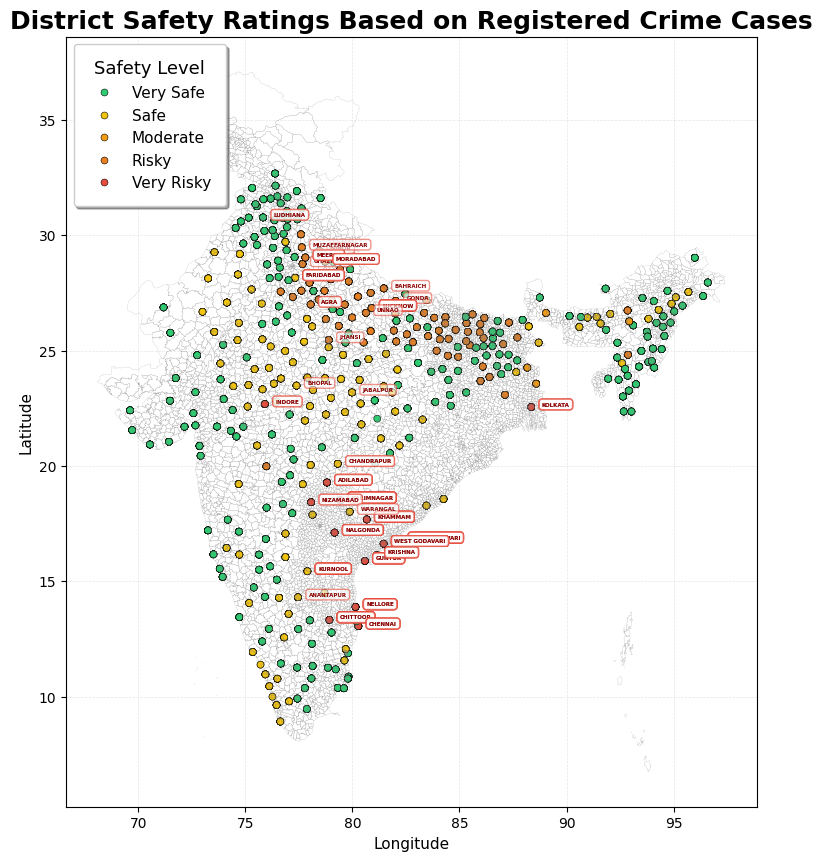

In [13]:
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Path to your shapefile (replace with your actual shapefile path)
india_shapefile = '../datasets/crime analytics/shape_files/INDIAN-SHAPEFILES/INDIA/INDIAN_SUB_DISTRICTS.geojson'

# Load the shapefile using GeoPandas
gdf = gpd.read_file(india_shapefile)

# Create the plot
fig, ax = plt.subplots(figsize=(15, 10))

# Plot the basemap (district boundaries)
gdf.boundary.plot(ax=ax, linewidth=0.1, edgecolor='gray')

# Create a custom color palette
custom_palette = {0: '#2ECC71',   # Green (Very Safe)
                  1: '#F1C40F',   # Yellow-Green (Safe)
                  2: '#F39C12',   # Orange (Moderate)
                  3: '#E67E22',   # Deep Orange (Risky)
                  4: '#E74C3C'}   # Red (Very Risky)

# Plot the clusters
sns.scatterplot(x='Longitude', y='Latitude', hue='Cluster', data=dw_caw_latlong, 
                s=25, marker='o', palette=custom_palette, edgecolor='black', ax=ax)

# Highlight the highest risk clusters with annotations (e.g., Cluster 4)
for i, row in dw_caw_latlong[dw_caw_latlong['Cluster'] == 4].iterrows():
    ax.text(row['Longitude'] + 0.5, row['Latitude'] + 0.05, row['District'], 
            fontsize=4, weight='bold', color='darkred', 
            bbox=dict(facecolor='white', alpha=0.6, edgecolor='#E74C3C', boxstyle='round,pad=0.5'))

# Add customizations for visual appeal
ax.set_title('District Safety Ratings Based on Registered Crime Cases', fontsize=18, weight='bold')
ax.set_xlabel('Longitude', fontsize=11)
ax.set_ylabel('Latitude', fontsize=11)

# Customize the legend
handles, labels = ax.get_legend_handles_labels()
labels = ['Very Safe', 'Safe', 'Moderate', 'Risky', 'Very Risky']
ax.legend(handles, labels, title='Safety Level', loc='upper left', 
          title_fontsize='13', fontsize='11', frameon=True, fancybox=True, framealpha=1, shadow=True, borderpad=1)

# Add gridlines for better geographical understanding
ax.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.2)

# Show the plot
plt.show()


In [14]:
import geopandas as gpd
import rasterio
from rasterio.features import geometry_mask
from rasterio.transform import from_origin
import numpy as np

# Load the shapefile
geojson_file = '../datasets/crime analytics/shape_files/INDIAN-SHAPEFILES/INDIA/INDIAN_SUB_DISTRICTS.geojson'
gdf = gpd.read_file(geojson_file)

# Define the size and resolution of the raster
pixel_size = 0.01  # Adjust based on your needs
bounds = gdf.total_bounds
width = int((bounds[2] - bounds[0]) / pixel_size)
height = int((bounds[3] - bounds[1]) / pixel_size)

# Create the transform object
transform = from_origin(bounds[0], bounds[3], pixel_size, pixel_size)

# Create a new raster file
with rasterio.open(
    'rasterized_shapefile.tif',
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,
    dtype=rasterio.uint8,
    crs=gdf.crs,
    transform=transform
) as dst:
    # Rasterize the shapefile
    rasterized = rasterio.features.rasterize(
        [(geom, 1) for geom in gdf.geometry],
        out_shape=(height, width),
        transform=transform
    )
    dst.write(rasterized, 1)


In [15]:
dw_caw_latlong.head(1)

,State,District,Latitude,Longitude,Year,Rape,Kidnapping and Abduction,Dowry Deaths,Assault on women with intent to outrage her modesty,Insult to modesty of Women,Cruelty by Husband or his Relatives,Importation of Girls,Cluster
0,ANDHRA PRADESH,ADILABAD,19.284514,78.813212,2001,50,30,16,149,34,175,0,1


In [49]:
import plotly.express as px
import plotly.io as pio
custom_palette = {0: '#2ECC71',   # Green (Very Safe)
                  1: '#F1C40F',   # Yellow-Green (Safe)
                  2: '#F39C12',   # Orange (Moderate)
                  3: '#E67E22',   # Deep Orange (Risky)
                  4: '#E74C3C'}   # Red (Very Risky)
custom_color_scale = [
    [0, '#2ECC71'],       # Green (Very Safe)
    [0.25, '#9BCE7A'],     # Light Green
    [0.5, '#F1C40F'],      # Yellow-Green (Safe)
    [0.75, '#F39C12'],     # Orange (Moderate)
    [1, '#E74C3C']         # Red (Very Risky)
]
# Create the figure (you already have this part)
fig = px.density_mapbox(dw_caw_latlong, lat='Latitude', lon='Longitude', z='Cluster', radius=25,
                        center=dict(lat=20.5937, lon=82.9629),
                        zoom=5,
                        mapbox_style='carto-darkmatter',
                        color_continuous_scale=custom_color_scale)

# Save the figure as a high-resolution PNG file
pio.write_image(fig, 'density_map.png', width=1600, height=1600, scale=2)


The 'colorscale' property is a colorscale and may be
    specified as:
      - A list of colors that will be spaced evenly to create the colorscale.
        Many predefined colorscale lists are included in the sequential, diverging,
        and cyclical modules in the plotly.colors package.
      - A list of 2-element lists where the first element is the
        normalized color level value (starting at 0 and ending at 1),
        and the second item is a valid color string.
        (e.g. [[0, 'green'], [0.5, 'red'], [1.0, 'rgb(0, 0, 255)']])
      - One of the following named colorscales:
            ['aggrnyl', 'agsunset', 'algae', 'amp', 'armyrose', 'balance',
             'blackbody', 'bluered', 'blues', 'blugrn', 'bluyl', 'brbg',
             'brwnyl', 'bugn', 'bupu', 'burg', 'burgyl', 'cividis', 'curl',
             'darkmint', 'deep', 'delta', 'dense', 'earth', 'edge', 'electric',
             'emrld', 'fall', 'geyser', 'gnbu', 'gray', 'greens', 'greys',
             'haline', 'hot', 'hsv', 'ice', 'icefire', 'inferno', 'jet',
             'magenta', 'magma', 'matter', 'mint', 'mrybm', 'mygbm', 'oranges',
             'orrd', 'oryel', 'oxy', 'peach', 'phase', 'picnic', 'pinkyl',
             'piyg', 'plasma', 'plotly3', 'portland', 'prgn', 'pubu', 'pubugn',
             'puor', 'purd', 'purp', 'purples', 'purpor', 'rainbow', 'rdbu',
             'rdgy', 'rdpu', 'rdylbu', 'rdylgn', 'redor', 'reds', 'solar',
             'spectral', 'speed', 'sunset', 'sunsetdark', 'teal', 'tealgrn',
             'tealrose', 'tempo', 'temps', 'thermal', 'tropic', 'turbid',
             'turbo', 'twilight', 'viridis', 'ylgn', 'ylgnbu', 'ylorbr',
             'ylorrd'].